# Introduction

I used a **Deep Q-Network (DQN)** for the RL agent, because the observation space is continuous. Traditional Q-learning is not applicable without discretising the observation space, as the Q-value needs to be calculated for each state-action pair, and would lead to a very large Q-table. Using a DQN gets Q-values using a neural network to approximate the Q-function.

[Reference](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

### Installing packages

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip3 install --upgrade numpy==1.26 2>&1
!pip3 install --upgrade setuptools==65.5.0 "wheel<0.40.0"
!pip3 install gym==0.25.2 pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip3 install gym[classic_control]
!pip3 install ez_setup > /dev/null 2>&1


  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### Defining helper functions and setting up the environment


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count

device = torch.device("cpu")

env = gym.make("CartPole-v1")

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Task 1: Development of an RL agent

##Replay memory
 - The agent store the transitions (`state, action, next_state, reward`) observed in a replay buffer. The `capacity` is the max number of transitions stored in the buffer.
 - Sampling only the most recent transitions leads to high temporal correlation. By randomly sampling the `batch_size`, the transitions are decorrelated, stabilising training.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##DQN
- extends the neural network module from Pytorch `torch.nn`
- takes in the 4 observations `cart position`, `cart velocity`, `pole angle` and `pole angular velocity` as input
- outputs the Q-value for the 2 actions `left` and `right`
- `forward` passes input `x` through 3 `relu` (Rectified Linear Unit) activations to introduce non-linearity, and returns the Q-value

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        layer_size = 128

        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, layer_size)
        self.layer2 = nn.Linear(layer_size, 512)
        self.layer3 = nn.Linear(512, layer_size)
        self.layer4 = nn.Linear(layer_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

#RL agent
##Hyperparameters
- `BATCH_SIZE`: sampling batch_size for `ReplayMemory`
- `GAMMA`: discount factor for future rewards  
  
####Epsilon ϵ  
There is ϵ probability of the agent taking a random action, to balance exploration and exploitation.
- `EPS_START`: starting value
- `EPS_END`: final value
- `EPS_DECAY`: rate of exponential decay  

####Policy network optimisation
The **policy network** is the main Q-network -- predicted Q-values for the current state. The **target network** -- target Q-values for the next state, is **periodically updated**. Huber loss function computes the difference between the predicted Q-values and target Q-values, and **AdamW optimiser** is used to update the policy weights. Huber loss is less sensitive to outliers than mean squared loss. AdamW uses weight decay to prevent overfitting. **Gradient clipping** ensures updates are not too large, to stabilise training.
- `TAU`: update rate of the target network
- `LR`: learning rate of the [AdamW optimizer](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

In [ ]:
class DQN_Agent():
    def __init__(self, num_eps, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr):
        self.NUM_EPISODES = num_eps
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.EPS_START = eps_start
        self.EPS_END = eps_end
        self.EPS_DECAY = eps_decay
        self.TAU = tau
        self.LR = lr

        self.n_actions = env.action_space.n
        state = env.reset()
        self.n_observations = len(state)

        self.policy_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

        self.eps_done = 0


    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1) #pick action with larger reward
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch) #compute Q-values for current state-action pairs

        next_state_values = torch.zeros(self.BATCH_SIZE, device=device) #compute expected future reward for all next states
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch #compute target Q-values


        criterion = nn.SmoothL1Loss() #compute Huber loss
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad() #AdamW optimiser
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) #gradient clipping
        self.optimizer.step()

    def train(self, state, train=True):
        action = self.select_action(state)
        observation, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        self.memory.push(state, action, next_state, reward) #append transition to replay buffer


        if train: self.optimize_model()

        target_net_state_dict = self.target_net.state_dict() #update target network
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)

        return next_state, action.item(), done

    def training_loop(self, train=True, display='Training'):
        for episode in range(self.eps_done, self.NUM_EPISODES):
            state = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                state, _, done = self.train(state, train)

                if done:
                    episode_results.append(t + 1)
                    plot_results(display=display)
                    break
            self.eps_done += 1

##Training RL agent
`plot_results` is used to plot the training results and results for Task 2. The running average of `window_size` episodes is plotted, starting from `window_size` number of episodes.

In [ ]:
episode_results = []


def plot_results(show_result=False, display='Training'):
    plt.figure(1)
    rewards_t = torch.tensor(episode_results, dtype=torch.float)

    plt.clf()
    plt.title(display)
    plt.xlabel('episode')
    plt.ylabel('Cumulative reward')
    plt.plot(rewards_t.numpy())

    window_size=100 #running average
    if len(rewards_t) >= window_size:
        means = rewards_t.unfold(0, window_size, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(window_size-1), means))
        plt.plot(means.numpy())

    plt.pause(0.001) #for training loop
    if not show_result:
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    else:
        ipythondisplay.display(plt.gcf())

These are the initial hyperparameters.

In [ ]:
agent = DQN_Agent(
    num_eps=200,
    batch_size=128,
    gamma=0.99,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=1000,
    tau=0.005,
    lr=1e-4
)

Complete


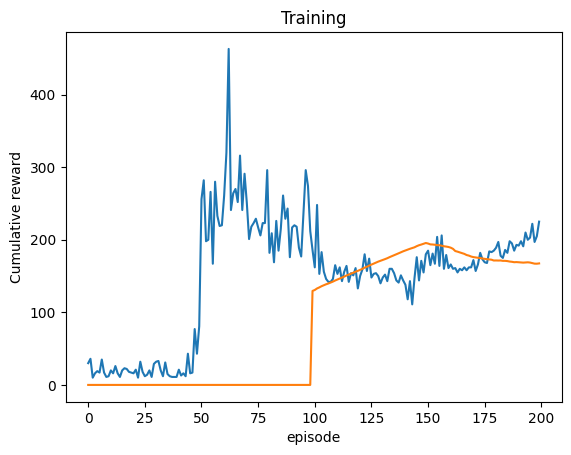

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent.training_loop()

print('Complete')
plot_results(show_result=True)
plt.ioff()
plt.show()

The observation and chosen action for **Task 1**.

In [ ]:
observation = env.reset()
action = agent.select_action(torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0))
print("Observation:", observation)
print("Chosen action:", action.item())

Observation: [ 0.00526521  0.01212336 -0.00610294  0.02461551]
Chosen action: 1


###Tuning Hyperparameters
Using the initial agent as a base, I vary different hyperparameters while holding other hyperparameters constant.

####Decrease ϵ decay
I increase the value of `eps_decay`. ϵ remains high for longer, encouraging exploration, as it increases the probability of the agent taking a random action.



Complete


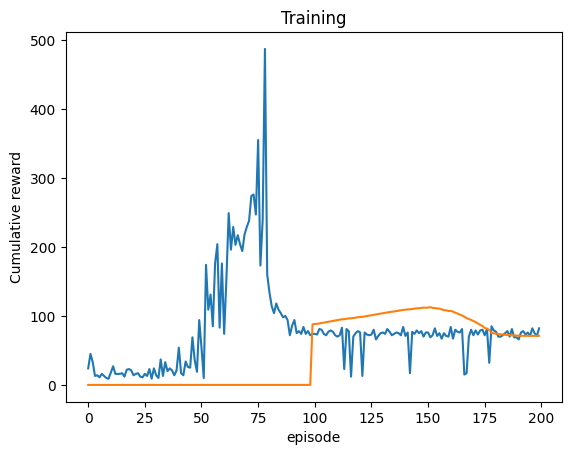

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent = DQN_Agent(
    num_eps=200,
    batch_size=128,
    gamma=0.99,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=2000,
    tau=0.005,
    lr=1e-4
)

episode_results = []

agent.training_loop()

print('Complete')
plot_results(show_result=True)
plt.ioff()
plt.show()

####Increase learning rate
I increase the value of `lr`. The AdamW optimiser updates the policy network faster, although there is risk of instability and Q-values might not converge.

Complete


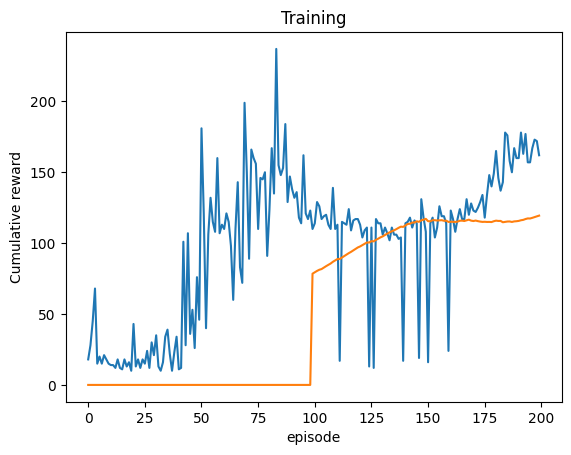

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent = DQN_Agent(
    num_eps=200,
    batch_size=128,
    gamma=0.99,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=1000,
    tau=0.005,
    lr=1e-3
)

episode_results = []

agent.training_loop()

print('Complete')
plot_results(show_result=True)
plt.ioff()
plt.show()

####Increase batch size
I increase the value of `batch_size`. More transitions sampled for gradient estimation, making convergence of Q-values smoother.

Complete


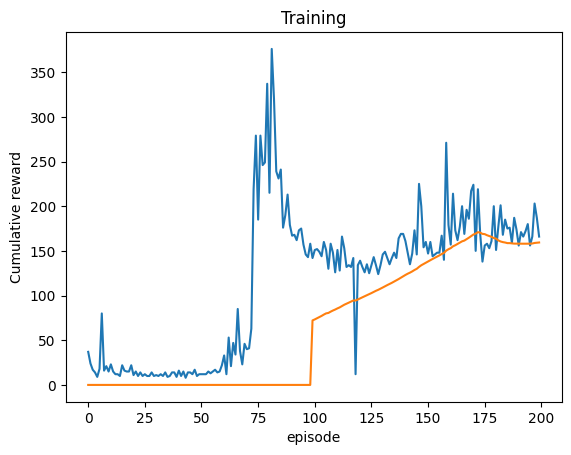

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent = DQN_Agent(
    num_eps=200,
    batch_size=256,
    gamma=0.99,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=1000,
    tau=0.005,
    lr=1e-4
)

episode_results = []

agent.training_loop()

print('Complete')
plot_results(show_result=True)
plt.ioff()
plt.show()

####Final hyperparameters
I increase batch size and number of episodes.

Complete


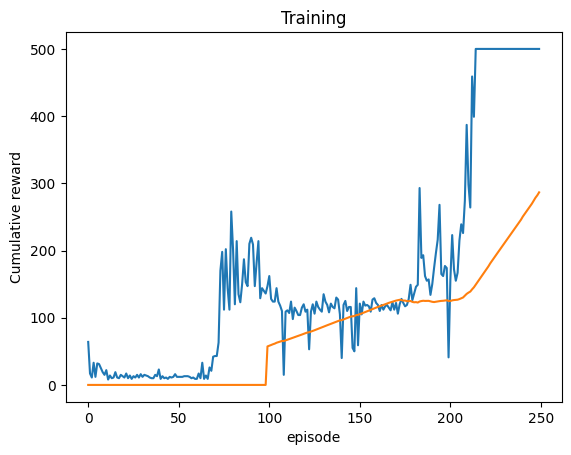

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
agent = DQN_Agent(
    num_eps=250,
    batch_size=256,
    gamma=0.99,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=1000,
    tau=0.005,
    lr=1e-4
)

episode_results = []

agent.training_loop()

print('Complete')
plot_results(show_result=True)
plt.ioff()
plt.show()

Saving the trained model:

In [ ]:
torch.save(agent.policy_net.state_dict(), "DQN_agent.pth")

## Task 2: Demonstrate the effectiveness of the RL agent

Loading the trained model:

In [ ]:
agent.policy_net.load_state_dict(torch.load("DQN_agent.pth"))
agent.policy_net.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=2, bias=True)
)

Using the RL agent I play 100 episodes.

Complete


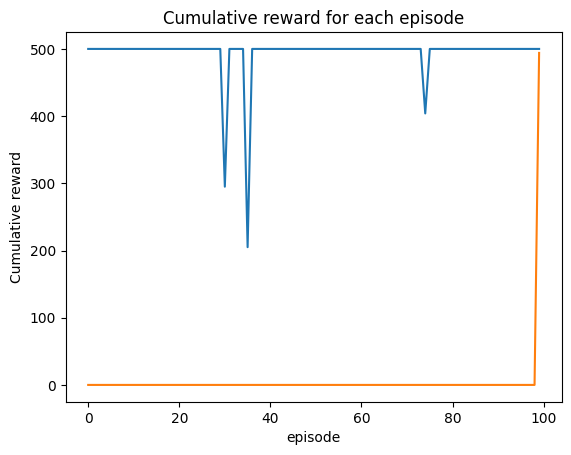

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
episode_results = []

agent.NUM_EPISODES = 100
agent.eps_done = 0
agent.training_loop(train=False, display='Cumulative reward for each episode')

print('Complete')
plot_results(show_result=True, display='Cumulative reward for each episode')
plt.ioff()
plt.show()

The average reward over the 100 episodes:


In [ ]:
np_results = np.asarray(episode_results)
print("Average cumulative reward:", np_results.mean())
print("Is my agent good enough?", np_results.mean() > 195)

Average cumulative reward: 494.04
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Rendering one episode using the RL agent.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

while True:
    env.render()
    #your agent goes here
    action = agent.select_action(observation)
        # print(action.item())
    observation, reward, done, info = env.step(action.item())
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    if done:
      break;

env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
